In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import mediapipe as mp

import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb

import joblib

In [3]:
model_path = './hand_landmarker.task'

In [16]:
df = pd.read_csv('./versions/dataset_xyz.csv')
df.head()

,label,keypoints
0,A,"[(0.5160611271858215, 0.7950515747070312, -7.2..."
1,A,"[(0.5043174028396606, 0.7688353061676025, -3.6..."
2,A,"[(0.5133167505264282, 0.8641117811203003, -4.2..."
3,A,"[(0.5338877439498901, 0.7778040766716003, -6.5..."
4,A,"[(0.5210541486740112, 0.8094577789306641, -7.5..."


In [17]:
image = eval(df.loc[0, 'keypoints'])

# Extract x, y, and z coordinates from image
x = [coord[0] for coord in image]
y = [coord[1] for coord in image]
z = [coord[2] for coord in image]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

# Add lines connecting the points
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines', line=dict(color='blue', width=2)))

# Set labels and title
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'), title='3D Plot of Coordinates')

# Show the plot
fig.show()


In [18]:
joint_list = [[4,3,2], [8,7,6], [12,11,10], [16,15,14], [20,19,18]]

In [20]:
def draw_finger_angles(keypoints, joint_list):
    list_angles = []
    for joint in joint_list:
        a = keypoints[joint[0]]
        b = keypoints[joint[1]]
        c = keypoints[joint[2]]
        radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
        angle = np.abs(radians * 180.0 / np.pi)
        if angle > 180.0:
            angle = 360 - angle
        list_angles.append(angle)
    return list_angles

In [21]:
# Iterate over the rows of the dataframe
for index, row in df.iterrows():
    keypoints = eval(row['keypoints'])
    angles = draw_finger_angles(keypoints, joint_list)
    
    # Add the angles as new columns to the dataframe
    for i, angle in enumerate(angles):
        column_name = f'Angle_{i+1}'
        df.loc[index, column_name] = angle


In [22]:
df.head()

,label,keypoints,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5
0,A,"[(0.5160611271858215, 0.7950515747070312, -7.2...",168.064241,170.749289,172.299434,173.483256,171.859274
1,A,"[(0.5043174028396606, 0.7688353061676025, -3.6...",173.490061,178.698236,179.537005,179.986749,178.034921
2,A,"[(0.5133167505264282, 0.8641117811203003, -4.2...",169.506552,169.982852,171.867547,169.729956,165.238714
3,A,"[(0.5338877439498901, 0.7778040766716003, -6.5...",178.123659,162.300432,164.233809,163.050348,146.869520
4,A,"[(0.5210541486740112, 0.8094577789306641, -7.5...",179.247352,170.643276,175.673820,173.457268,163.117709


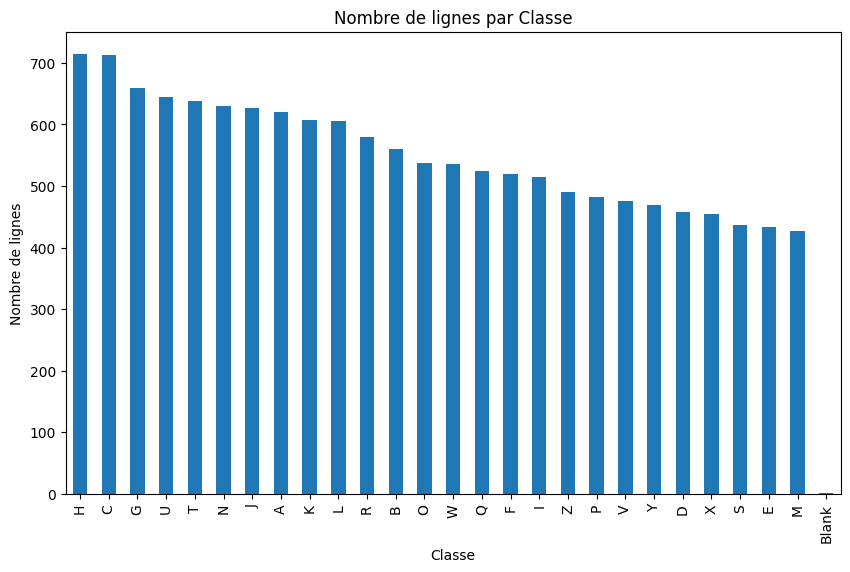

In [23]:
class_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre de lignes')
plt.title('Nombre de lignes par Classe')
plt.show()

In [24]:
num_rows_M = len(df[df['label'] == 'M'])
print(num_rows_M)

427


In [25]:
seuil_bas = 25
seuil_haut = 427

classes_to_keep = class_counts[class_counts >= seuil_bas].index
df_filtered = pd.DataFrame(columns=df.columns)
for classe in classes_to_keep:
    df_classe = df[df['label'] == classe]
    if len(df_classe) > seuil_haut:
        df_classe = df_classe.head(seuil_haut)
    df_filtered = pd.concat([df_filtered, df_classe], ignore_index=True)

/tmp/ipykernel_24828/3479508080.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [26]:
df_filtered.head()

,label,keypoints,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5
0,H,"[(0.4206766188144684, 0.610883355140686, 2.333...",146.941762,168.484127,168.323694,170.637537,175.106490
1,H,"[(0.3816889822483063, 0.6490432620048523, 1.52...",172.405865,177.418176,172.934411,145.935090,145.748094
2,H,"[(0.6095360517501831, 0.6253103613853455, 3.13...",160.247280,175.541508,178.660258,143.175551,139.050996
3,H,"[(0.604487955570221, 0.6316844820976257, 3.031...",164.625646,173.799883,179.382315,157.805133,158.959287
4,H,"[(0.3648202419281006, 0.6226154565811157, 4.44...",162.604346,167.962832,169.131960,162.318180,168.596012


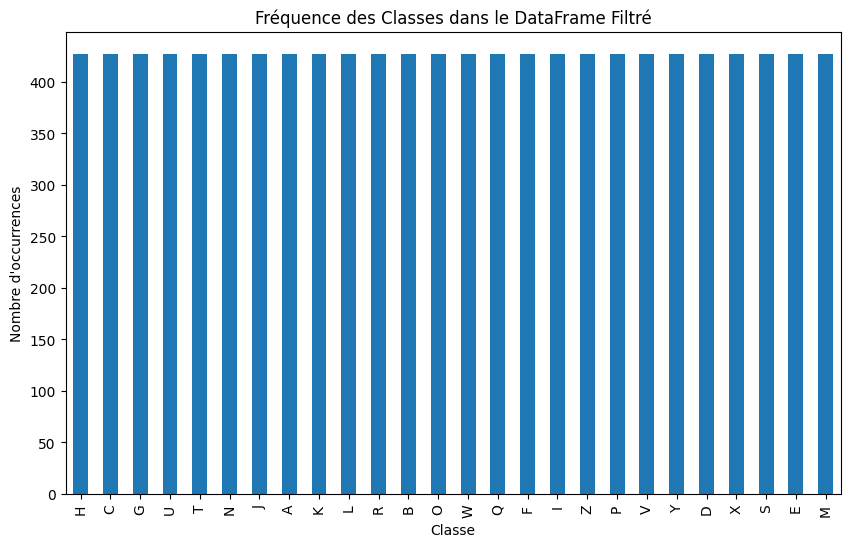

In [27]:
class_counts_filtered = df_filtered['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts_filtered.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'occurrences')
plt.title('Fréquence des Classes dans le DataFrame Filtré')
plt.show()

In [15]:
# def transform_tuples(row):
#     keypoints = eval(row)
#     return [coord for point in keypoints for coord in point]
# df_filtered['keypoints'] = df_filtered['keypoints'].apply(transform_tuples)

  label                                          keypoints     Angle_1  \
0     H  [0.4206766188144684, 0.610883355140686, 2.3337...  146.941762   
1     H  [0.3816889822483063, 0.6490432620048523, 1.525...  172.405865   
2     H  [0.6095360517501831, 0.6253103613853455, 3.136...  160.247280   
3     H  [0.604487955570221, 0.6316844820976257, 3.0319...  164.625646   
4     H  [0.3648202419281006, 0.6226154565811157, 4.443...  162.604346   

      Angle_2     Angle_3     Angle_4     Angle_5  
0  168.484127  168.323694  170.637537  175.106490  
1  177.418176  172.934411  145.935090  145.748094  
2  175.541508  178.660258  143.175551  139.050996  
3  173.799883  179.382315  157.805133  158.959287  
4  167.962832  169.131960  162.318180  168.596012  


In [20]:
# df_filtered['keypoints_length'] = df_filtered['keypoints'].apply(len)

# incorrect_keypoints = df_filtered[df_filtered['keypoints_length'] != 63]

# print("Lignes avec un nombre incorrect de keypoints :")
# print(incorrect_keypoints[['label', 'keypoints_length']])

Lignes avec un nombre incorrect de keypoints :
Empty DataFrame
Columns: [label, keypoints_length]
Index: []


In [25]:
# list_of_lists = df_filtered.apply(lambda row: row['keypoints'] + [row[f'Angle_{i}'] for i in range(1, 6)], axis=1).tolist()
# column_names = [f"{dim}{i}" for i in range(1, 22) for dim in ['x', 'y', 'z']] + [f"angle{j}" for j in range(1, 6)]
# df_data = pd.DataFrame(list_of_lists, columns=column_names)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,y20,z20,x21,y21,z21,angle1,angle2,angle3,angle4,angle5
0,0.420677,0.610883,2.333799e-07,0.430167,0.512329,0.061105,0.486282,0.455495,0.100139,0.539163,...,0.605711,0.095405,0.544453,0.611621,0.091943,146.941762,168.484127,168.323694,170.637537,175.106490
1,0.381689,0.649043,1.525978e-06,0.469686,0.559303,0.093047,0.540683,0.518047,0.061833,0.597782,...,0.638265,-0.123061,0.521425,0.637230,-0.091857,172.405865,177.418176,172.934411,145.935090,145.748094
2,0.609536,0.625310,3.136767e-07,0.584264,0.528664,0.042380,0.502393,0.467223,0.047012,0.402380,...,0.644857,-0.058803,0.438702,0.630606,-0.048356,160.247280,175.541508,178.660258,143.175551,139.050996
3,0.604488,0.631684,3.031942e-07,0.580859,0.517551,0.061562,0.497572,0.456244,0.085152,0.414914,...,0.635092,0.047836,0.447702,0.633287,0.047824,164.625646,173.799883,179.382315,157.805133,158.959287
4,0.364820,0.622615,4.443094e-07,0.392628,0.515623,0.077282,0.467863,0.462701,0.099570,0.530102,...,0.612616,0.059907,0.508017,0.616386,0.062065,162.604346,167.962832,169.131960,162.318180,168.596012


In [15]:
# random_examples = df_filtered.groupby('label').apply(lambda x: x.sample(1, random_state=42))

# for index, row in random_examples.iterrows():
#     label = row['label']
#     angles = [row[f'Angle_{i+1}'] for i in range(5)]
#     print(f"Label: {label}")
#     print(f"Angles: {angles}")
#     print()


/tmp/ipykernel_24828/2628861570.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



KeyError: 'Angle_1'

In [37]:
df_filtered.head()

,label,keypoints,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5
0,H,"[(0.4206766188144684, 0.610883355140686, 2.333...",146.941762,168.484127,168.323694,170.637537,175.106490
1,H,"[(0.3816889822483063, 0.6490432620048523, 1.52...",172.405865,177.418176,172.934411,145.935090,145.748094
2,H,"[(0.6095360517501831, 0.6253103613853455, 3.13...",160.247280,175.541508,178.660258,143.175551,139.050996
3,H,"[(0.604487955570221, 0.6316844820976257, 3.031...",164.625646,173.799883,179.382315,157.805133,158.959287
4,H,"[(0.3648202419281006, 0.6226154565811157, 4.44...",162.604346,167.962832,169.131960,162.318180,168.596012


In [28]:
X = df_filtered.drop(columns=['label', 'keypoints'])
y = df_filtered['label']

In [29]:
X.head()

,Angle_1,Angle_2,Angle_3,Angle_4,Angle_5
0,146.941762,168.484127,168.323694,170.637537,175.106490
1,172.405865,177.418176,172.934411,145.935090,145.748094
2,160.247280,175.541508,178.660258,143.175551,139.050996
3,164.625646,173.799883,179.382315,157.805133,158.959287
4,162.604346,167.962832,169.131960,162.318180,168.596012


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier()
]

for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5) 
    print(f"Model: {type(model).__name__}")
    print(f"Cross-validation scores: {scores}")
    print(f"Mean score: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

/home/mathieu/projects/asl_web_app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/mathieu/projects/asl_web_app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Model: LogisticRegression
Cross-validation scores: [0.49803039 0.50168919 0.50957207 0.52027027 0.50619369]
Mean score: 0.5071511227040209
Standard deviation: 0.007640814261583097
Model: DecisionTreeClassifier
Cross-validation scores: [0.61001688 0.625      0.61768018 0.6295045  0.60247748]
Mean score: 0.6169358089096413
Standard deviation: 0.009802777846384081
Model: RandomForestClassifier
Cross-validation scores: [0.7332583  0.73310811 0.72184685 0.73254505 0.70945946]
Mean score: 0.7260435519931863
Standard deviation: 0.009347453346946704
Model: SVC
Cross-validation scores: [0.6747327  0.65765766 0.67342342 0.66441441 0.65146396]
Mean score: 0.6643384310027529
Standard deviation: 0.008955090511564227
Model: KNeighborsClassifier
Cross-validation scores: [0.72988182 0.72635135 0.7240991  0.71846847 0.70551802]
Mean score: 0.720863752046926
Standard deviation: 0.008522156558818321


In [32]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

scores = cross_val_score(model_xgb, X_train, y_train_encoded, cv=5)

print(f"Model: {type(model_xgb).__name__}")
print(f"Cross-validation scores: {scores}")
print(f"Mean score: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.72481711 0.72466216 0.72297297 0.71509009 0.70495495]
Mean score: 0.7184994575329409
Standard deviation: 0.007654819476583538


In [33]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

param_grid = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model_xgb.set_params(**param_grid)
model_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

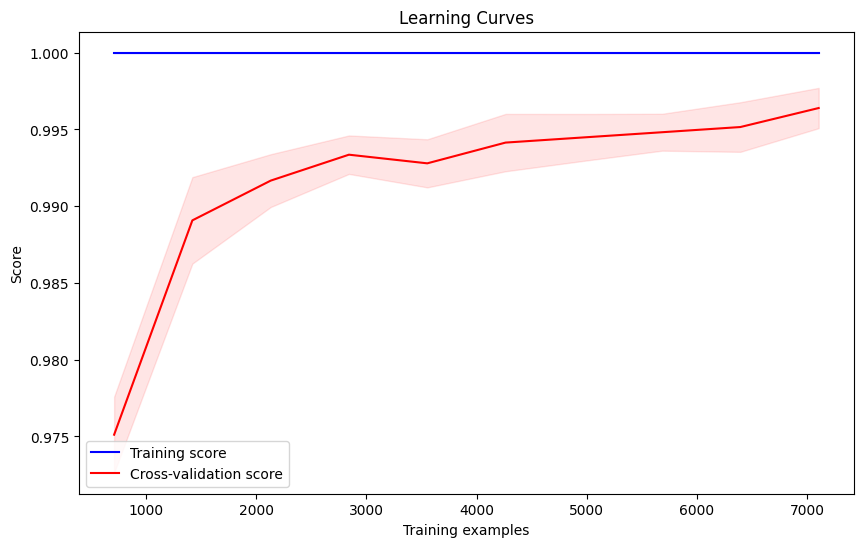

In [42]:
# Define the number of training examples to use for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(model_xgb, X_train, y_train_encoded, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='red')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [34]:
y_pred = model_xgb.predict(X_test)
report = classification_report(y_test_encoded, y_pred)
cm = confusion_matrix(y_test_encoded, y_pred)
print("Rapport de classification :")
print(report)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.69      0.72      0.71        98
           1       0.93      0.92      0.92        84
           2       0.76      0.85      0.80        91
           3       0.76      0.66      0.70        87
           4       0.87      0.86      0.86        69
           5       0.93      0.93      0.93        86
           6       0.80      0.88      0.83        80
           7       0.76      0.71      0.73        93
           8       0.80      0.85      0.82        79
           9       0.95      0.97      0.96        72
          10       0.64      0.67      0.66        87
          11       0.70      0.70      0.70        99
          12       0.73      0.61      0.66       100
          13       0.59      0.63      0.61        86
          14       0.84      0.96      0.90        90
          15       0.84      0.71      0.77        86
          16       0.75      0.58      0.65        83

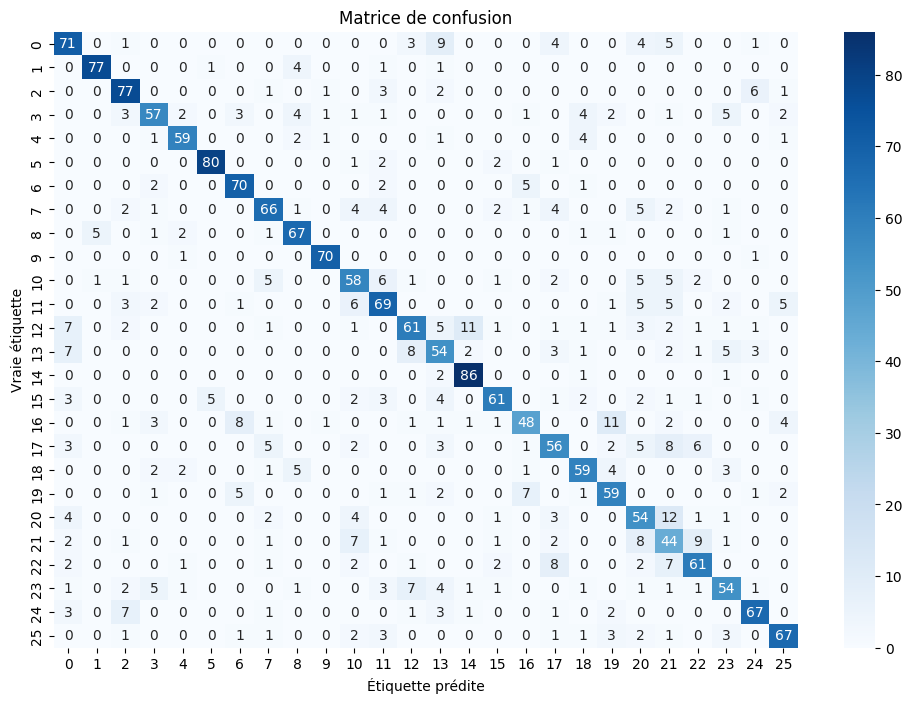

In [35]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.title('Matrice de confusion')
plt.show()

In [36]:
joblib.dump(model_xgb, 'model_xgb_angles_only_v1.pkl')

['model_xgb_angles_only_v1.pkl']